In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import sys
sys.path.insert(0,'../')
import utils
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, TimeDistributed, Concatenate, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
import sys
sys.modules.pop('utils')
import utils
import random
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time as time0
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

plt.rcParams.update({'font.size': 20})
max_words = 50000

# LSTM model (2 Inputs)

In [2]:
def eval_model(model, x_train, y_train, x_test, y_test):
    print("Training time: {:0.3f} s".format(time9-time8))

    start_time = time0.time()
    pred = model.predict(x_test)
    end_time = time0.time()
    print("Inference time: {:0.3f} s".format(end_time-start_time))
    
    test_accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
    print("Testing Accuracy: {:0.3f}".format(test_accuracy))

    # Confusion matrix
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    pred = (model.predict(x_train) >= 0.5) * 1   
    cm = confusion_matrix(y_train, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax=ax)
    ax.set_title('Training Set Performance');

    ax = fig.add_subplot(1, 2, 2)
    pred = (model.predict(x_test) >= 0.5) * 1   
    cm = confusion_matrix(y_test, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax=ax)
    ax.set_title('Testing Set Performance');
    plt.savefig(filename+"_confusion_matrix")

    # Record results
    file = open('figures/model_record.txt', 'a')
    file.write('Model ' + model_number + '\n')
    file.write('Number of Epochs used: ' + str(epoch_used) + '\n')
    file.write("Training time: {:0.3f} s\n".format(time9-time8))
    file.write("Inference time: {:0.3f} s\n".format(end_time - start_time))
    file.write("Testing Accuracy: {:0.3f}\n".format(test_accuracy))
    file.write("Classification report:\n{0}\n\n".format(classification_report(y_test_int, pred)))
    file.close()

def plot_history(history):
    fig = plt.figure(figsize=[20, 20])
    
    # TRAIN and VALIDATION LOSS
    ax = fig.add_subplot(2, 1, 1)
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_title('Loss vs Epoch')

    # TRAIN and VALIDATION ACCURACY
    ax = fig.add_subplot(2, 1, 2)
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.legend()
    ax.set_title('Accuracy vs Epoch')
    
    plt.savefig(filename+'_history')

## Load data

In [74]:
# Load data
x_train, y_train, x_val, y_val, x_test, y_test = utils.load_data('../train.csv')

# Clean data, remove nan, 
x_train["location"] = x_train.location.fillna("")
cols = ['following', 'followers', 'actions']
x_train_imp, imputer = utils.impute_dataframe(x_train, cols, verbose=True)
x_train_imp = x_train_imp.dropna()

x_val["location"] = x_val.location.fillna("")
x_val_imp_intermediate = pd.DataFrame(imputer.transform(x_val[cols]), columns=imputer.feature_names_in_, index=x_val.index)
x_val_imp = x_val.copy()
x_val_imp[cols] = x_val_imp_intermediate[cols]
# print(x_val_imp.shape)
# print(True in x_val_imp.isna())

x_test["location"] = x_test.location.fillna("")
x_test_imp_intermediate = pd.DataFrame(imputer.transform(x_test[cols]), columns=imputer.feature_names_in_, index=x_test.index)
x_test_imp = x_test.copy()
x_test_imp[cols] = x_test_imp_intermediate[cols]
# print(x_test_imp.shape)
# print(True in x_test_imp.isna())


# Remove the same rows containing nan in y as well
y_train = y_train[y_train.index.intersection(x_train_imp.index)]
y_val = y_val[y_val.index.intersection(x_val_imp.index)]
y_test = y_test[y_test.index.intersection(x_test_imp.index)]

# Tokenise tweet and convert to Tensor shape
x_traincopy = x_train_imp.copy()
x_valcopy = x_val_imp.copy()
x_testcopy = x_test_imp.copy()

x_train_tweet, x_val_tweet, x_test_tweet, \
x_train_las, x_val_las, x_test_las, \
max_length, tokenizer = utils.tokenise(x_traincopy.iloc[:,0], x_valcopy.iloc[:,0], x_testcopy.iloc[:,0])

# Reshape input for our model's demand
x_train_tweet = np.array(x_train_tweet.reshape(x_train_tweet.shape[0], max_length, 1))
x_val_tweet = np.array(x_val_tweet.reshape(x_val_tweet.shape[0], max_length, 1))
x_test_tweet = np.array(x_test_tweet.reshape(x_test_tweet.shape[0], max_length, 1))

# Transform y for compatability
y_train_int, y_val_int, y_test_int = \
    utils.transform_to_float(y_train.copy(), y_val.copy(), y_test.copy())


# Check
print('\nx shape   y shape')
print(x_train_imp.shape, y_train.shape)
print(x_val_imp.shape, y_val.shape)
print(x_test_imp.shape, y_test.shape)

print('\nx tweet shape')
print(x_train_tweet.shape)
print(x_val_tweet.shape)
print(x_test_tweet.shape)

item = 3
print('Original tweet:')
print(x_train.iloc[item,0])
print('Checking symbols seperation:')
print(x_train_las[item])
print('Checking tokenized:')
print(x_train_tweet[item])


x shape   y shape
(8968, 6) (8968,)
(1500, 6) (1500,)
(1500, 6) (1500,)
(8968, 6) (8968, 6)
NAN Counts:
 Tweet         0
following     0
followers     0
actions       0
is_retweet    1
location      0
dtype: int64
(1500, 6)
False
(1500, 6)
False

x shape   y shape
(8967, 6) (8967,)
(1500, 6) (1500,)
(1500, 6) (1500,)

x tweet shape
(8967, 105, 1)
(1500, 105, 1)
(1500, 105, 1)
Original tweet:
he's decent guy but yeah, has zero chill  with anything Arsenal related.
Checking symbols seperation:
he ' s decent guy but yeah ,  has zero chill with anything arsenal related . 
Checking tokenized:
[[  64]
 [   8]
 [  23]
 [3199]
 [ 478]
 [  70]
 [ 571]
 [  12]
 [  76]
 [2296]
 [2297]
 [  30]
 [ 498]
 [2022]
 [2690]
 [   1]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [  

In [4]:
# Correlation matrix
temp = x_train_imp.copy()
temp['Type'] = np.array(y_train_int)
temp.corr()

,following,followers,actions,is_retweet,Type
following,1.000000,0.224465,0.022243,-0.044804,0.002049
followers,0.224465,1.000000,-0.006848,-0.025569,-0.087561
actions,0.022243,-0.006848,1.000000,0.055427,0.284933
is_retweet,-0.044804,-0.025569,0.055427,1.000000,0.366117
Type,0.002049,-0.087561,0.284933,0.366117,1.000000


In [5]:
# Standardise ['following', 'followers', 'actions', 'is_retweet'] columns
x_train_others, x_val_others, x_test_others = \
    utils.standardise(x_train_imp, x_val_imp, x_test_imp, ['following', 'followers', 'actions', 'is_retweet'])

# Keep these columns seperate in different vars
x_train_others = x_train_others.iloc[:,1:5]
x_val_others = x_val_others.iloc[:,1:5]
x_test_others = x_test_others.iloc[:,1:5]

print(x_test_others.head(3))
print(x_train_others.shape)

   following  followers   actions  is_retweet
0   0.183545  -0.089778  0.531621   -0.537166
1  -0.158538  -0.092859 -0.505179   -0.537166
2   0.005769  -0.086534  0.116873   -0.537166
(8967, 4)


## Build model

In [13]:
batch_size = 128
model_number = '22'

########################### Main model 4 ############################
inputA = Input(shape = (max_length,1), name = 'tokenised_tweets')
x = LSTM(128, return_sequences=True)(inputA)
x = LSTM(64)(x)
# x = LSTM(128)(inputA)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)


inputB = Input(shape=(4,1), name='others')
y = Flatten()(inputB)
y = Dense(4, activation='relu')(y)

combined = concatenate([x,y])
output = Dense(32, activation='relu')(combined)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)
lstm_model_2i = Model([inputA, inputB], output)

lstm_model_2i.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# lstm_model_2i.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tokenised_tweets (InputLayer)   [(None, 105, 1)]     0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 105, 128)     66560       tokenised_tweets[0][0]           
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 64)           49408       lstm_4[0][0]                     
__________________________________________________________________________________________________
others (InputLayer)             [(None, 4, 1)]       0                                            
____________________________________________________________________________________________

## Train 

In [11]:
filename = f"figures/model_{model_number}_{random.randint(1000,9999)}"
modelfilename = filename+'.h5'
history_filename = filename+'_history'

checkpoint = ModelCheckpoint(modelfilename, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
earlystopping = EarlyStopping(monitor='val_loss', patience=20)

time8 = time0.time()
history = lstm_model_2i.fit(
            x=(x_train_tweet, x_train_others), 
            y=y_train_int,
            batch_size=batch_size,
            epochs=300,
            validation_data=([x_val_tweet, x_val_others], y_val_int),
            callbacks=[earlystopping, checkpoint])
time9 = time0.time()

lstm_model_2i.load_weights(modelfilename)
utils.savedata(history.history, filename+'_history')
epoch_used = len(history.history['val_accuracy'])

Epoch 1/300
71/71 [==============================] - 15s 181ms/step - loss: 0.6377 - accuracy: 0.6841 - val_loss: 0.5873 - val_accuracy: 0.7173

Epoch 00001: val_loss improved from inf to 0.58733, saving model to figures\model_22_9348.h5
Epoch 2/300
71/71 [==============================] - 12s 174ms/step - loss: 0.5515 - accuracy: 0.7550 - val_loss: 0.6198 - val_accuracy: 0.6900

Epoch 00002: val_loss did not improve from 0.58733
Epoch 3/300
71/71 [==============================] - 12s 173ms/step - loss: 0.5593 - accuracy: 0.7538 - val_loss: 0.5421 - val_accuracy: 0.7547

Epoch 00003: val_loss improved from 0.58733 to 0.54207, saving model to figures\model_22_9348.h5
Epoch 4/300
71/71 [==============================] - 13s 179ms/step - loss: 0.5350 - accuracy: 0.7639 - val_loss: 0.5299 - val_accuracy: 0.7580

Epoch 00004: val_loss improved from 0.54207 to 0.52992, saving model to figures\model_22_9348.h5
Epoch 5/300
71/71 [==============================] - 12s 167ms/step - loss: 0.5202

In [ ]:
# # Load trained model weights from a selected file
# time9,time8 = 0,0
# lstm_model.load_weights("LSTM/figures/model_02_official/model_22_974.h5")

Training time: 3986.034 s
Inference time: 1.347 s
47/47 [==============================] - 1s 28ms/step - loss: 0.0791 - accuracy: 0.9700 0s - loss: 0.074
Testing Accuracy: 0.970


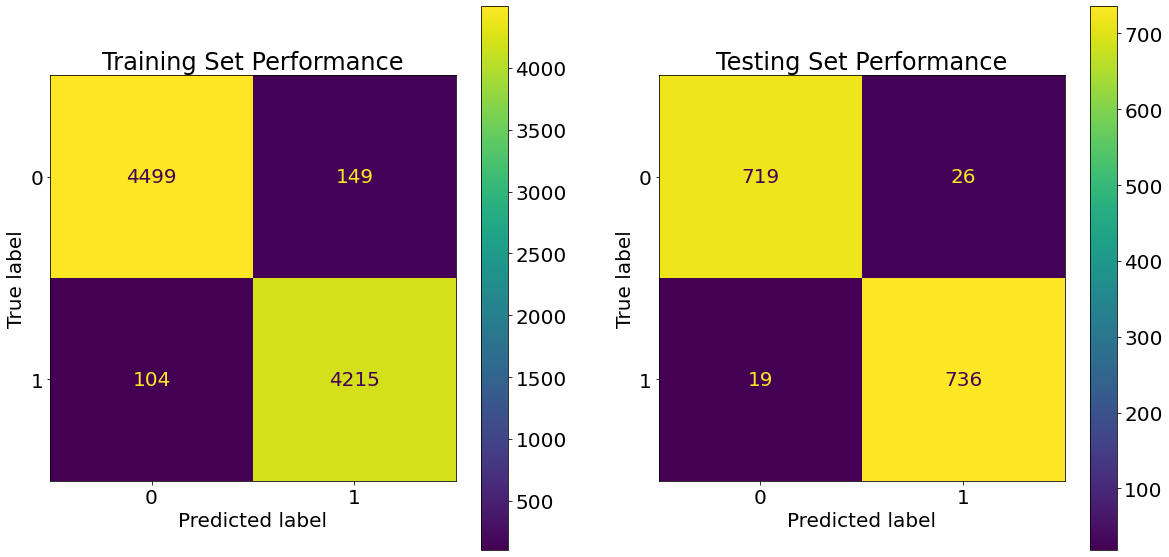

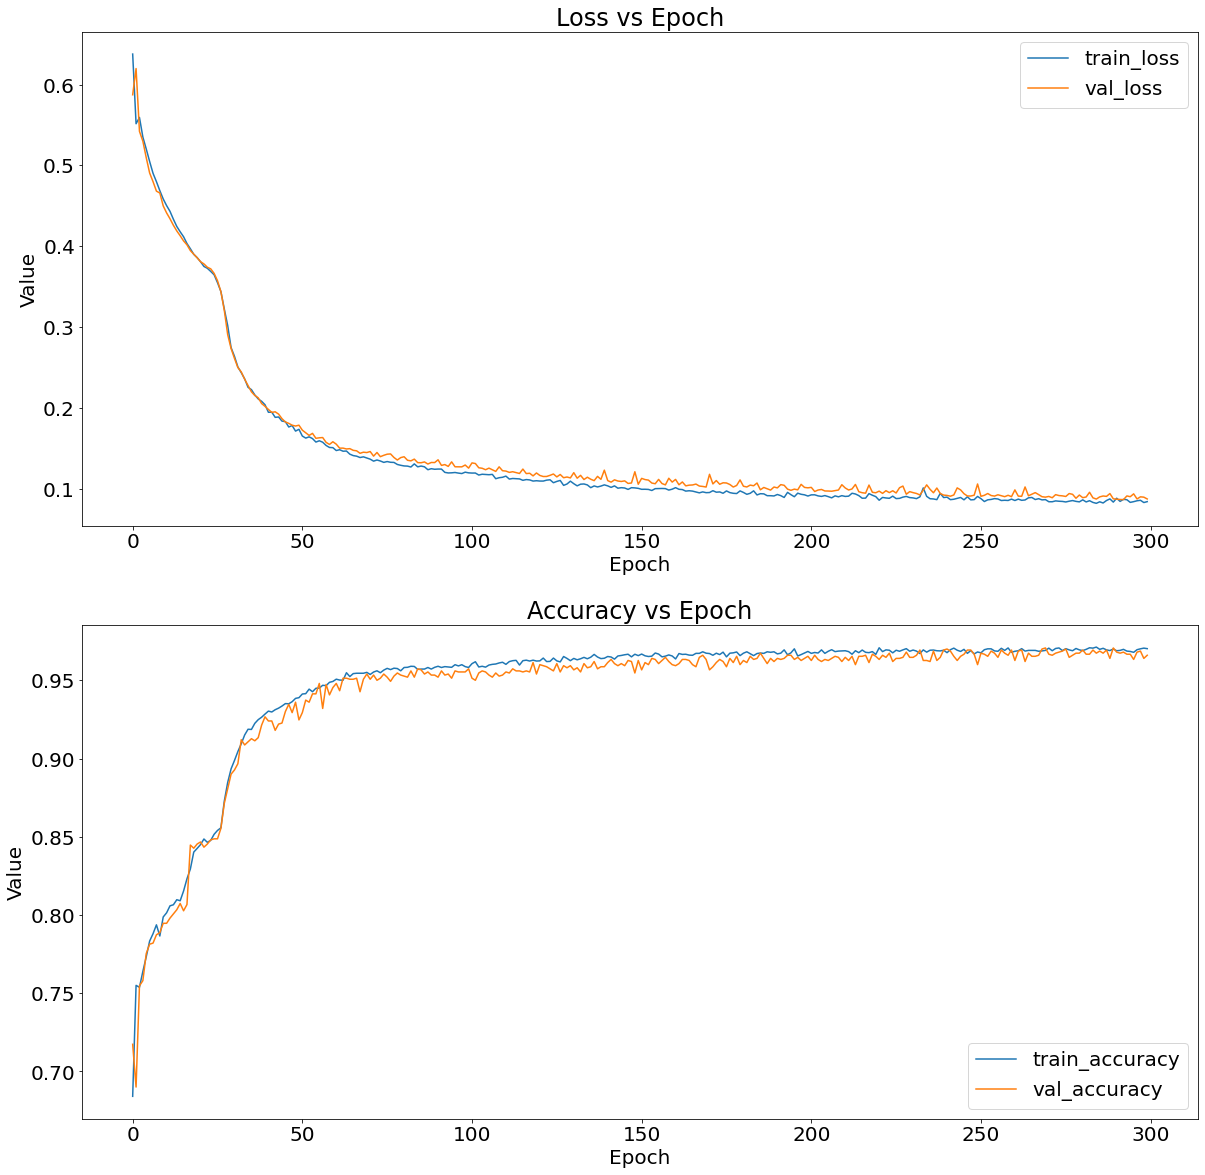

In [14]:
eval_model(lstm_model_2i, [x_train_tweet, x_train_others], y_train_int, \
                          [x_test_tweet, x_test_others], y_test_int)
plot_history(history.history)

In [21]:
# lstm_model_2i.load_weights("figures/model_02_official/model_02_969.h5")
pred_test = (lstm_model_2i.predict([x_test_tweet, x_test_others]) >= 0.5) * 1
pred_train = (lstm_model_2i.predict([x_train_tweet, x_train_others]) >= 0.5) * 1  

In [ ]:
print(pred_train.shape)
print(y_train_int.shape)
pred_train_df = pd.DataFrame(pred_train)
y_train_df = pd.DataFrame(y_train_int)
correct = pred_train_df[pred_train_df == y_train_df]
correct = correct.dropna()
print(correct.shape)
y_train_df.rename(columns = {0:'actual'}, inplace = True)

## Get TP, FP, TN, FN predictions cases

In [ ]:
x_tokenised_string = [str(list(i)) for i in x_train_tweet.reshape(8967,105)]
x_filtered_train = pd.DataFrame(x_train_las.reset_index()).join(x_train_others)
x_filtered_train.insert(1, 'tokenised', pd.DataFrame(x_tokenised_string)[0])
print(x_filtered_train.shape)

x_filtered_train['actual'] = pd.DataFrame(y_train_int)
print(x_filtered_train.shape)

x_filtered_train['pred'] = pred_train
print(x_filtered_train.shape)


x_filtered_train_true = x_filtered_train[x_filtered_train['actual'] == x_filtered_train['pred']]
x_filtered_train_false = x_filtered_train[x_filtered_train['actual'] != x_filtered_train['pred']]
print(pred_train.shape, x_filtered_train.shape)
print(x_filtered_train_true.shape, x_filtered_train_false.shape)

train_true_positive = x_filtered_train_true[x_filtered_train_true['actual'] == 1]
train_true_negative = x_filtered_train_true[x_filtered_train_true['actual'] == 0]
train_false_positive = x_filtered_train_false[x_filtered_train_false['pred'] == 1]
train_false_negative = x_filtered_train_false[x_filtered_train_false['pred'] == 0]
print(train_true_positive.shape, train_true_negative.shape, train_false_positive.shape, train_false_negative.shape) 

train_true_positive.to_csv("figures/model_02_official/model_02_train_TP_cases.csv")
train_true_negative.to_csv("figures/model_02_official/model_02_train_TN_cases.csv")
train_false_positive.to_csv("figures/model_02_official/model_02_train_FP_cases.csv")
train_false_negative.to_csv("figures/model_02_official/model_02_train_FN_cases.csv")

In [80]:
x_test_tokenised_string = [str(list(i)) for i in x_test_tweet.reshape(x_test_tweet.shape[0],x_test_tweet.shape[1])]
x_filtered_test = pd.DataFrame(x_test_las.reset_index()).join(x_test_others)
x_filtered_test.insert(1, 'tokenised', pd.DataFrame(x_test_tokenised_string)[0])
print(x_filtered_test.shape)

x_filtered_test['actual'] = pd.DataFrame(y_test_int)
print(x_filtered_test.shape)

x_filtered_test['pred'] = pred_test
print(x_filtered_test.shape)


x_filtered_test_true = x_filtered_test[x_filtered_test['actual'] == x_filtered_test['pred']]
x_filtered_test_false = x_filtered_test[x_filtered_test['actual'] != x_filtered_test['pred']]


test_true_positive = x_filtered_test_true[x_filtered_test_true['pred'] == 1]
test_true_negative = x_filtered_test_true[x_filtered_test_true['pred'] == 0]
test_false_positive = x_filtered_test_false[x_filtered_test_false['pred'] == 1]
test_false_negative = x_filtered_test_false[x_filtered_test_false['pred'] == 0]
print(test_true_positive.shape, test_true_negative.shape, test_false_positive.shape, test_false_negative.shape) 

test_true_positive.to_csv("figures/model_02_official/model_02_test_TP_cases.csv")
test_true_negative.to_csv("figures/model_02_official/model_02_test_TN_cases.csv")
test_false_positive.to_csv("figures/model_02_official/model_02_test_FP_cases.csv")
test_false_negative.to_csv("figures/model_02_official/model_02_test_FN_cases.csv")

(1500, 7)
(1500, 8)
(1500, 9)
(728, 9) (725, 9) (20, 9) (27, 9)


(-1.0, 3.5)

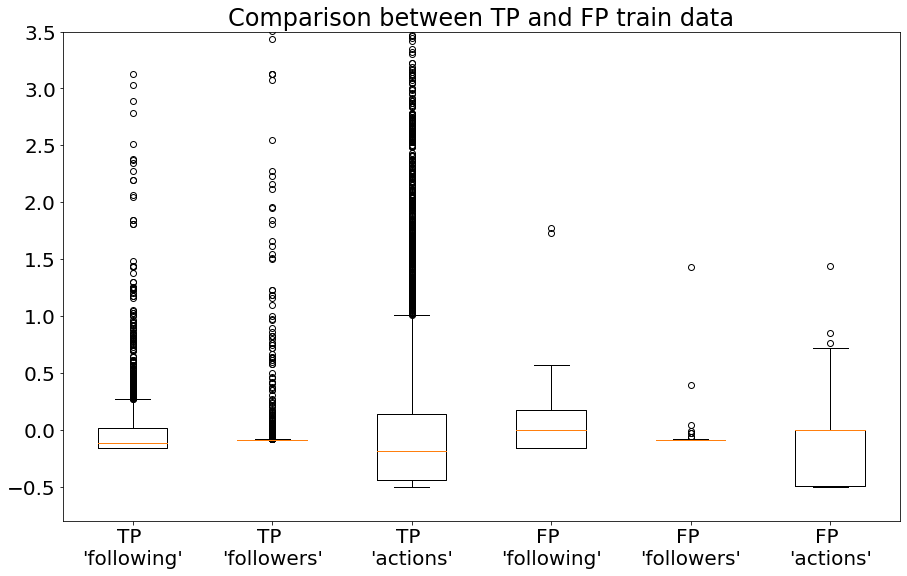

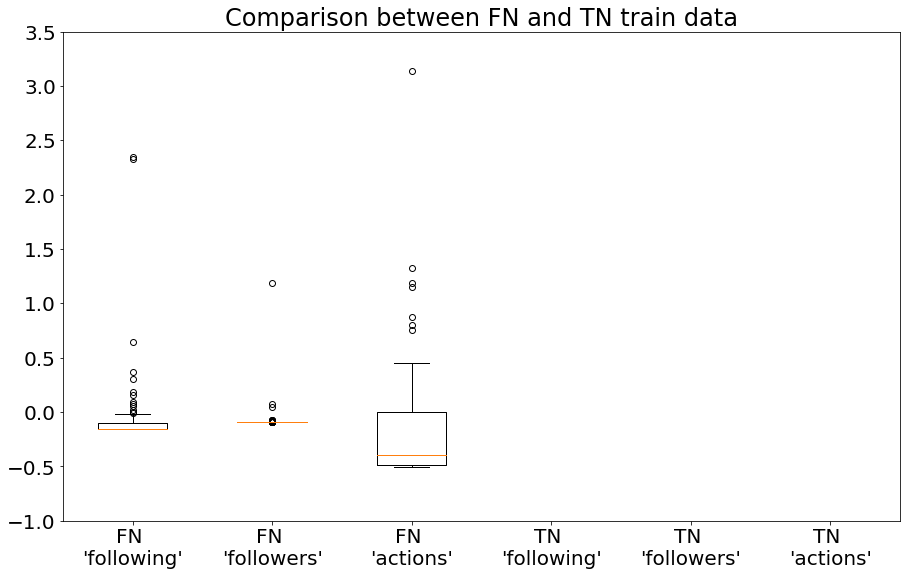

In [176]:
fig = plt.figure(figsize=(15,9))
ax=fig.add_subplot(1,1,1)
ax.boxplot([train_true_positive["following"], train_true_positive["followers"], train_true_positive["actions"],
    train_false_positive["following"], train_false_positive["followers"], train_false_positive["actions"]],
    labels=("TP \n'following'", "TP \n'followers'", 
            "TP \n'actions'", "FP \n'following'", 
            "FP \n'followers'", "FP \n'actions'"));
ax.set_title("Comparison between TP and FP train data")
ax.set_ylim(-0.8, 3.5)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.boxplot([train_false_negative["following"], train_false_negative["followers"], train_false_negative["actions"],
    train_true_negative["following"], train_true_negative["followers"], train_true_negative["actions"]],
    labels=("FN \n'following'", "FN \n'followers'", 
            "FN \n'actions'", "TN \n'following'", 
            "TN \n'followers'", "TN \n'actions'"));
ax.set_title("Comparison between FN and TN train data")
ax.set_ylim(-1, 3.5)


In [ ]:
y_test_int = np.array(y_test_int)
mask = np.transpose(pred_test) == y_test_int
print(mask.shape)
mask = np.transpose(mask)
mask = np.array(mask)
np.reshape(mask, (mask.shape[0]))
print(mask.shape)

correct_examples = pd.DataFrame()
incorrect_examples = pd.DataFrame()

x_test['Spam'] = y_test_int
correct_examples = x_test[mask]
incorrect_examples = x_test[mask == False]

x_test_tweet_new = pd.DataFrame(x_test_tweet.reshape(1500,x_test_tweet.shape[1]))
correct_tokenised = x_test_tweet_new[mask]
incorrect_tokenised = x_test_tweet_new[mask == False]

import ast
vocab = tokenizer.get_config()['word_counts']
vocab = ast.literal_eval(vocab)
print('Checking: \n', {k: vocab[k] for k in list(vocab)[:20]})

utils.savedata([correct_examples, incorrect_examples, \
            correct_tokenised, incorrect_tokenised,
            vocab], filename+"_vocab")

## Analyse failed cases


In [14]:
x_train_spam = x_traincopy[y_train == 'Spam']
x_train_quality = x_traincopy[y_train == 'Quality']

_,_,_,_,_,_, max_length, tokenizer_train_spam = utils.tokenise(x_train_spam.iloc[:,0], x_testcopy.iloc[:,0], x_testcopy.iloc[:,0])
_,_,_,_,_,_, max_length, tokenizer_train_quality = utils.tokenise(x_train_quality.iloc[:,0], x_testcopy.iloc[:,0], x_testcopy.iloc[:,0])

In [116]:
def num_matching_words_for_a_tweet(atweet, tokenizer_train_quality, tokenizer_train_spam):
    global quality_count_larger, spam_count_larger
    dict_quality = tokenizer_train_quality.word_counts
    dict_spam = tokenizer_train_spam.word_counts
    output = pd.DataFrame(columns=['word', 'quality_count', 'spam_count'])
    for i in  atweet.split():
        if i not in dict_quality.keys():
            dict_quality[i] = 0
        if i not in dict_spam.keys():
            dict_spam[i] = 0

        output.loc[len(output.index)] = [i, dict_quality[i], dict_spam[i]]

    output.loc[len(output.index)] = ['TOTAL', output.quality_count.sum(), output.spam_count.sum()]
    
    # count and use global vars
    if (output.quality_count.sum()>output.spam_count.sum()):
        quality_count_larger +=1
    else:
        spam_count_larger += 1
    return output

def num_matching_words(tweets):
    for atweet in tweets:
        num_matching_words_for_a_tweet(atweet, tokenizer_train_quality, tokenizer_train_spam)
    print(f"spam_count_larger: {spam_count_larger}\nquality_count_larger: {quality_count_larger}")

In [115]:
spam_count_larger = 0
quality_count_larger = 0
num_matching_words(test_false_positive.Tweet.iloc[:])

spam_count_larger: 5
quality_count_larger: 15


In [119]:
index = 14
output = num_matching_words_for_a_tweet(test_false_positive.Tweet.iloc[index],
                                    tokenizer_train_quality, tokenizer_train_spam)


print('Index in LSTM\'s False Positive cases: '+str(index))
output

Index in LSTM's False Positive cases: 14


,word,quality_count,spam_count
0,diving,0,0
1,into,50,48
2,some,89,37
3,makeup,5,0
4,art,18,5
5,today,97,46
6,3,61,54
7,#,2126,3180
8,litcosmetics,0,0
9,#,2126,3180


Total vocabulary

In [75]:
len(tokenizer.word_counts)

28078

---

# Additional: LSTM model (3 Inputs)

In [ ]:
# Tokenising location
x_train_location, x_val_location, x_test_location, \
x_train_location_las, x_val_location_las, x_test_location_las, \
max_length_location, tokenizer_location = tokenise(x_traincopy.iloc[:,5], x_valcopy.iloc[:,5], x_testcopy.iloc[:,5])

# Reshape input for our model's demand
x_train_location = np.array(x_train_location.reshape(x_train_location.shape[0], max_length_location, 1))
x_val_location = np.array(x_val_location.reshape(x_val_location.shape[0], max_length_location, 1))
x_test_location = np.array(x_test_location.reshape(x_test_location.shape[0], max_length_location, 1))

In [ ]:
# Set up model
batch_size = 128
model_number = '03'

########################### Main model 3 ############################
inputA = Input(shape = (max_length,1), name = 'tokenised_tweets')
x = LSTM(128, return_sequences=True)(inputA)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)


inputB = Input(shape=(4,1), name='others')
y = Flatten()(inputB)
y = Dense(4, activation='relu')(y)

inputC = Input(shape = (max_length_location,1), name = 'tokenised_locations')
z = LSTM(64, return_sequences=True)(inputC)
z = LSTM(32)(z)
z = Dropout(0.2)(z)
z = Dense(16, activation='relu')(z)

combined = concatenate([x,y,z])
output = Dense(32, activation='relu')(combined)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)
lstm_model_3i = Model([inputA, inputB, inputC], output)

lstm_model_3i.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_model_3i.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tokenised_tweets (InputLayer)   [(None, 105, 1)]     0                                            
__________________________________________________________________________________________________
tokenised_locations (InputLayer [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 105, 128)     66560       tokenised_tweets[0][0]           
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 28, 64)       16896       tokenised_locations[0][0]        
______________________________________________________________________________________________

In [ ]:
# Training !
filename = f"figures/model_{model_number}_{random.randint(1000,9999)}"
modelfilename = filename+'.h5'
checkpoint = ModelCheckpoint(modelfilename, verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
earlystopping = EarlyStopping(monitor='val_loss', patience=25)

time8 = time0.time()
history = lstm_model_3i.fit(
            x=(x_train_tweet, x_train_others, x_train_location), 
            y=y_train_int,
            batch_size=batch_size,
            epochs=300,
            validation_data=([x_val_tweet, x_val_others, x_val_location], y_val_int),
            callbacks=[earlystopping, checkpoint])
time9 = time0.time()

lstm_model_3i.load_weights(modelfilename)
utils.savedata(history.history, filename+'_history')
epoch_used = len(history.history['val_accuracy'])

Epoch 1/300
71/71 [==============================] - 34s 404ms/step - loss: 0.5910 - accuracy: 0.6877 - val_loss: 0.4858 - val_accuracy: 0.6933

Epoch 00001: val_loss improved from inf to 0.48580, saving model to figures\model_03_3491.h5
Epoch 2/300
71/71 [==============================] - 25s 350ms/step - loss: 0.4757 - accuracy: 0.7518 - val_loss: 0.4926 - val_accuracy: 0.7700

Epoch 00002: val_loss did not improve from 0.48580
Epoch 3/300
71/71 [==============================] - 26s 373ms/step - loss: 0.4465 - accuracy: 0.8063 - val_loss: 0.4695 - val_accuracy: 0.8053

Epoch 00003: val_loss improved from 0.48580 to 0.46949, saving model to figures\model_03_3491.h5
Epoch 4/300
71/71 [==============================] - 29s 402ms/step - loss: 0.4215 - accuracy: 0.8245 - val_loss: 0.4424 - val_accuracy: 0.8167

Epoch 00004: val_loss improved from 0.46949 to 0.44243, saving model to figures\model_03_3491.h5
Epoch 5/300
71/71 [==============================] - 29s 407ms/step - loss: 0.4077

Training time: 1645.112 s
Inference time: 4.995 s
47/47 [==============================] - 3s 64ms/step - loss: 0.1486 - accuracy: 0.9520
Testing Accuracy: 0.952


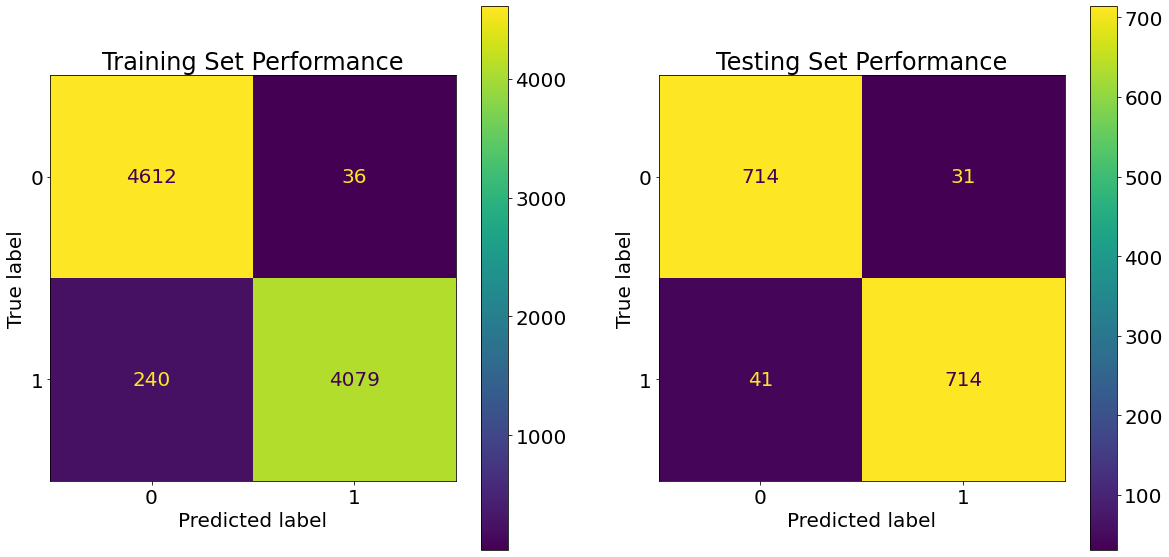

In [ ]:
eval_model(lstm_model_3i, [x_train_tweet, x_train_others, x_train_location], y_train_int, \
                          [x_test_tweet, x_test_others, x_test_location], y_test_int)

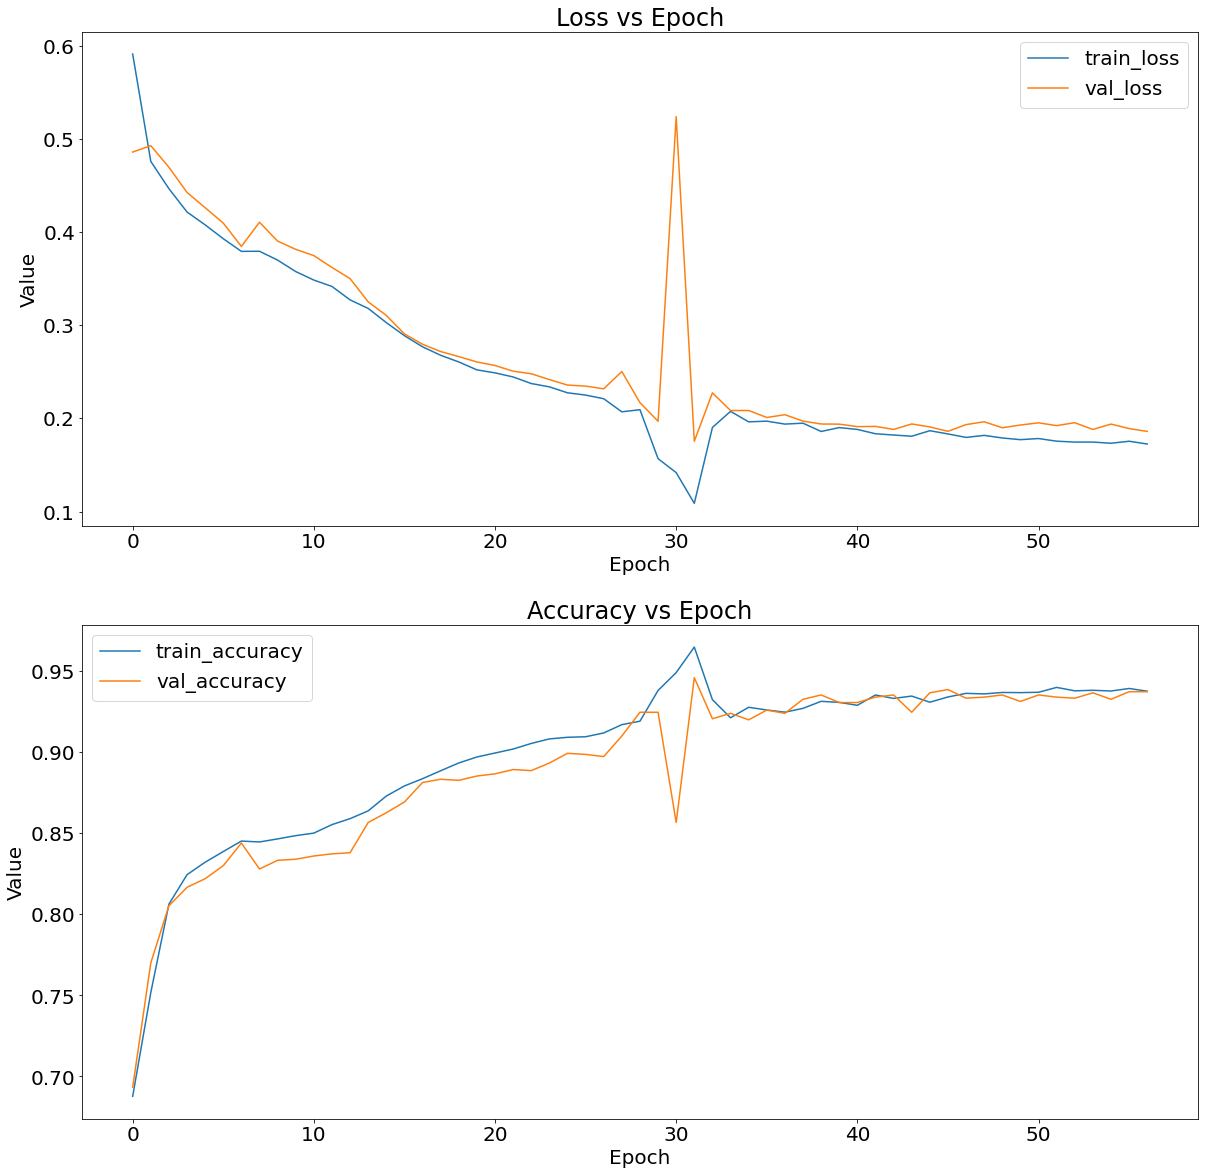

In [ ]:
plot_history(history.history)